In [1]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
import numpy as np
import time
import os

# 计时器
def timer (func):
    def wrapper(*args,**kwargs): 
        start = time.time()
        result = func(*args,**kwargs)
        end = time.time()
        print(func.__name__+'运行时间：',end-start)
        return result
    return wrapper

In [2]:
@timer
def load_train():
    # 导入数据
    train_df = joblib.load('../semi_super/x_train.lz4')
    y_train_df = train_df[['tag']]
    x_train_df = train_df.drop(columns=['tag'])
    x_train_df = x_train_df.fillna(-1)

    x_train_arr = x_train_df.values
    y_train_arr = y_train_df.values.ravel()
    return x_train_arr,y_train_arr

@timer
def load_unlabel():
    unlabel_df = joblib.load('../semi_super/x_unlabel.lz4')
    y_unlabel_df = unlabel_df[['tag']].copy()
    x_unlabel_df = unlabel_df.drop(columns=['tag'])
    x_unlabel_df = x_unlabel_df.fillna(-1)
    
    y_unlabel_arr = y_unlabel_df.tag.values.ravel()
    x_unlabel_arr = x_unlabel_df.values
    return x_unlabel_arr,y_unlabel_arr

In [3]:
x_train_arr,y_train_arr = load_train()
x_unlabel_arr,y_unlabel_arr = load_unlabel()

load_train运行时间： 7.500000953674316
load_unlabel运行时间： 16.499998807907104


In [9]:
def SelectModel(model_name):
    if model_name == 'XGB':
        from xgboost import XGBClassifier

        model = XGBClassifier(max_depth=6,
                              learning_rate =0.04, 
                              booster='gbtree',
                              objective='binary:logistic',
                              early_stopping_rounds=100,
                              scale_pos_weight=13,
                              eval_metric='auc',
                              gamma=1,
                              reg_lambda=1,
                              subsample=0.9,
                              min_child_weight=1,
                              seed=2018,
                              silent=False,
                              n_jobs=24,
                              num_boost_round =300
                             )
    elif model_name == 'RFC':
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=2000,
                                       n_jobs =36,
                                       max_features='sqrt',
                                       class_weight='balanced',
#                                        verbose =1,
                                       random_state=2018)
    elif model_name == 'LGB':
        from lightgbm import LGBMClassifier
        model = LGBMClassifier(boost='gbdt',
                    num_leaves=135, 
                    scale_pos_weight=13,
                    max_depth=-1,
                    learning_rate=.05,
                    max_bin=200,
                    min_data_in_leaf= 60,
                    objective='binary',
                    metric='auc',
                    num_threads=32,
                    slient=False,
                    num_boost_round =300)
    else:
        pass
    
    return model

def get_score(clf,n_folds,x_train,y_train,x_base,y_base):
    n_train = x_train.shape[0]
    kf = KFold(n_splits=n_folds,random_state=2018)
    score = np.zeros((n_train,))
    
    for i,(train_index,test_index)in enumerate(kf.split(x_train,y_train)):
        kf_x_train = np.vstack((x_base,x_train[train_index]))
        kf_y_train = np.hstack((y_base,y_train[train_index]))
        kf_x_test = x_train[test_index]
        
        clf.fit(kf_x_train,kf_y_train)
        tmp_trafold = clf.predict_proba(kf_x_test)[:,1].ravel()
        score[test_index] = tmp_trafold
     
    return score



In [ ]:
%%time
# 第一级
model_list = ['RFC','XGB','LGB']
clf = SelectModel(model_list[0])
score = get_score(clf,5,x_unlabel_arr,y_unlabel_arr,x_train_arr,y_train_arr)
joblib.dump(score,'./unlabel_preds/{}.joblib'.format(model_list[0])) 
for model in model_list[1:]:
    clf = SelectModel(model)
    tmp = get_score(clf,5,x_unlabel_arr,y_unlabel_arr,x_train_arr,y_train_arr)
    joblib.dump(tmp,'./unlabel_preds/{}.joblib'.format(model)) 
    score += tmp
score = score/3

In [11]:
score

array([0.90582158, 0.95248864, 0.98765523, ..., 0.91065481, 0.91465507,
       0.97132189])

In [12]:
unlabel_id = pd.read_csv('../../preprocess_data_new/train_ax_nodup.csv',usecols=[0],skiprows=33465).values.ravel()
unlabel_tag_score = pd.DataFrame()
unlabel_tag_score['id'] = unlabel_id
unlabel_tag_score['score'] = score
unlabel_tag_score.to_csv('./unlabel_preds1/unlabel_tag_score.csv',index=False)

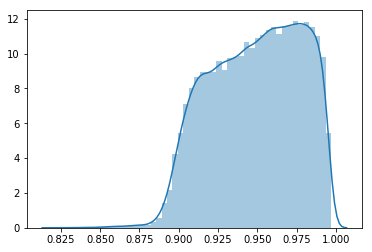

In [14]:
import seaborn as sns
%matplotlib inline
sns.distplot(score)

In [ ]:
score